## Multiunit recordings from several cortical areas

We will collect neurons from several cortical areas to perform population *dynamical* and *attractor* analysis, and get the *functional connectivity*.     
This will address three relevant points:
- Does the dynamic analysis hold at **higher temporal resolution**?
    - How do events statistics (duration and size) compare to 2-photon?
- Are population events only a **side-effect of behavior** (locomotion, whisker pad, pupil)?
    - Do behavioral components explain pattern reproducibility?
- Do **all areas of cortex** show attractor dynamics?
    - How do pattern trajectories compare to MICrONS?

To do all this, we analyse the [data](https://janelia.figshare.com/articles/dataset/Eight-probe_Neuropixels_recordings_during_spontaneous_behaviors/7739750/4) by [Stringer et al. 2019](science.org/doi/10.1126/science.aav7893).   
Eight-probe Neuropixels recordings in three mice during spontaneous activity.   

This notebook calls `dynamical_analysis.ipynb` and `attractor_analysis.ipynb`.

In [1]:
from platform import python_version
print(python_version())

%run -i 'imports_functions.py' 

%matplotlib inline

3.10.4


**WARNING**: the next cell takes time to download and unzip the neuropixel data.

In [2]:
if not os.path.exists("stringer/7739750.zip"):
    print("Downloading neuropixel data ...")
    if not os.path.exists("stringer"):
        os.makedirs("stringer")
    resp = wget.download("https://janelia.figshare.com/ndownloader/articles/7739750/versions/4", "stringer/7739750.zip")
    print("... Done: "+resp)

if not os.path.exists("stringer/7739750"):
    # unzip downloaded folder
    if os.path.exists("stringer/7739750.zip"):
        print("... unzipping")
        shutil.unpack_archive("stringer/7739750.zip", "stringer/7739750")
        shutil.unpack_archive("stringer/7739750/spks.zip", "stringer/7739750/spks")
        shutil.unpack_archive("stringer/7739750/faces.zip", "stringer/7739750/faces")
    print("Done.")
else:
    print("All data available.")

All data available.


### Data preprocessing

This analysis is based on the file `ephysLoad.m`.

Each "spks" is a structure of length 8, where each entry is a different probe (these probes were recorded simultaneously). It contains the spike times (in seconds, e.g. 4048.44929626 sec (?kHz sampling)), the cluster identity of each spike (its cell), and the height of each cluster on the probe.

The location of each site on the probe in microns in the Allen CCF framework is given in "ccfCoords". The brain area for each site is in "borders" as a function of the height of the site. 

We need the spikes from each area and probe to be separate lists. So, we build a dictionary to hold them, and save it locally as `area_spiketrains.npy`.

In [3]:
if os.path.exists("stringer/7739750/area_spiketrains.npy"):
    area_spiketrains = np.load("stringer/7739750/area_spiketrains.npy", allow_pickle=True).item()
    print("... loaded populations")
else:
    print("... collecting populations")
    
    probeLoc = sio.loadmat('stringer/7739750/probeLocations.mat')
    probeBorders = sio.loadmat('stringer/7739750/probeBorders.mat', squeeze_me=True)

    mouse_names = ['Krebs','Waksman','Robbins']
    cortical_areas = ['FrCtx','FrMoCtx','SomMoCtx','SSCtx','V1','V2','RSP']

    # first count the cells you want to take with this structure
    # then think on how you want to store the spikes... compatible with the dynamical_analysis
    area_spiketrains = {
        'Krebs' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]},
        'Waksman' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]},
        'Robbins' : {'FrCtx':[], 'FrMoCtx':[], 'SomMoCtx':[], 'SSCtx':[], 'V1':[], 'V2':[], 'RSP':[]}
    }

    for imouse in range(len(mouse_names)):
        print(mouse_names[imouse])

        spks = sio.loadmat('stringer/7739750/spks/spks%s_Feb18.mat'%mouse_names[imouse], squeeze_me=True)

        # probe k
        # k = 7
        for k in range(8):
            print("probe",k)

            # spike times (in seconds)
            st = spks['spks'][k][0]
            # clusters
            clu = spks['spks'][k][1]
            print("clusters (cells) of the spikes",len(np.unique(clu)))
            # cluster heights (in microns)
            # (see siteCoords to convert to site location)
            Wh = spks['spks'][k][2]

            # where is the probe in the brain (consolidated labels)
            # borders are in microns
            # use Wh to determine which clusters are in which brain region
            borders = probeBorders['probeBorders'][imouse]['borders'][k]
            for j in range(len(borders)):
                population = [] # one population per border, there can be several borders
                b = borders[j]
                if b[2] not in cortical_areas:
                    continue
                print('upper border %d um, lower border %d um, area %s'%(b[0],b[1],b[2]))
                wneurons = np.logical_and(Wh>=b[1], Wh<b[0])
                nn = wneurons.sum()
                print('%d neurons in %s'%(nn,b[-1]))
                # we should not include population smaller than those in MICrONS
                if nn<10:
                    print('population too small. Rejected.')
                    continue

                cortical_neurons = np.nonzero(wneurons)[0]
                for cn in cortical_neurons:
                    cn_idxs = [i for i in range(len(clu)) if clu[i]==cn]
                    # print(cn_idxs)
                    population.append( sorted(st[cn_idxs]) )
                    
                area_spiketrains[ mouse_names[imouse] ][ b[2] ].append( population )
            print()

    # save to file
    np.save("stringer/7739750/area_spiketrains.npy", area_spiketrains)


... loaded populations


The following spiketrains will be loaded.

| mouse | probe | borders (um) | area | #neurons |
|:----|:----|:----|:---|:---|
| **Krebs** | 0 | 4000, 1100 | FrMoCtx | 5 |
|           | 1 | 4000, 1800 | FrMoCtx | 73 |
|           | 2 | 4000, 2600 | V1 | 61 |
|           | 3 | 4000, 2400 | V1 | 141 |
|           | 4 | 4000, 1800 | SomMoCtx | 65 |
|           | 5 | 4000, 2100 | SomMoCtx | 26 |
|           | 6 | 4000, 2350 | V1 | 68 |
|           | 7 | 4000, 2600 | V1 | 64 |
| **Waksman** | 0 | 4000, 1700 | FrMoCtx | 446 |
|             | 0 | 1200, 0 | FrMoCtx | 201 |
|             | 1 | 4000, 2150 | FrCtx | 31 |
|             | 2 | 4000, 2700 | V1 | 155 |
|             | 3 | 4000, 2250 | RSP | 112 |
|             | 4 | 4000, 2000 | SomMoCtx | 220 |
|             | 5 | 4000, 2600 | SSCtx | 50 |
|             | 6 | 4000, 2650 | V2 | 124 |
|             | 7 | 4000, 2850 | V1 | 96 |
| **Robbins** | 0 | 4000, 3400 | FrMoCtx | 16 |
|             | 1 | 4000, 3100 | FrMoCtx | 70 |
|             | 3 | 4000, 3550 | RSP | 10 |
|             | 4 | 4000, 3500 | SomMoCtx | 10 |


In [4]:
real_frame_duration = 0.00000001 # sec (e.g. 4048.44929626 s)
# frame_duration = 0.001 # ms (e.g. 4048.449 s)
frame_duration = 0.01 # 10ms (e.g. 4048.45 s)
local_path = os.getcwd() + '/stringer/7739750/'

#### Note
The cell below is particularly long to execute if the dynamical and attractor analyses are used. We therefore used only the first mouse 'Krebs' to perform those analyses.     
However, functional correlations and hirarchical modularity are light enough to be performed on all mice (with a good bit of patience). By commenting the sections on 


mouse: Krebs
area:  FrMoCtx
population: 0
    time: 129215
    cells: 73
... Dynamical Analysis
    population firing: 2.84±2.85 sp/frame
    cells firing rate: 0.04±0.20 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 3.442972371621408
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 9656
    number of events per sec: 1.8921609355771718
    events duration: 0.100±0.040
    events size: 19.000±6.684
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.19066564490349733
    cluster size threshold: 2
    Total number of clusters: 246
    # clusters (after removing those below reproducibility threshold): 246
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
   

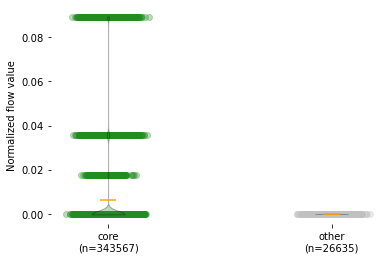


    Cut edges sourcing from cores: DescribeResult(nobs=56, minmax=(0.0, 328.125), mean=19.64540816326531, variance=4097.733539292341, skewness=3.5142318800378183, kurtosis=11.957554158300278)
    Cut edges targeting cores: DescribeResult(nobs=56, minmax=(0.0, 418.39285714285717), mean=19.64540816326531, variance=5898.687099125366, skewness=4.042100922420908, kurtosis=15.653447842929314)
    Cut edges sourcing from others: DescribeResult(nobs=17, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Cut edges targeting others: DescribeResult(nobs=17, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.000 p= 1.000
    Kolmogorov-Smirnov Effect Size: 0.054
    Core targets vs Other targets Welch t test:  1.914 p= 0.061
    Kolmogorov-Smirnov Effect Size: 0.125


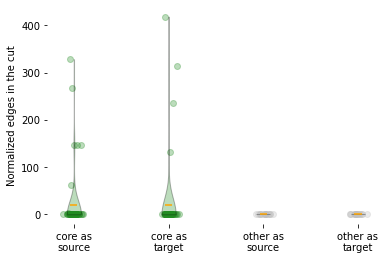

... PageRank centrality
    cores: DescribeResult(nobs=56, minmax=(0.010100175461192205, 0.11124364171712331), mean=0.017857142857142856, variance=0.0005230930590453082, skewness=3.037112360336873, kurtosis=8.028295882206187)
    others: DescribeResult(nobs=17, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  54.885 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


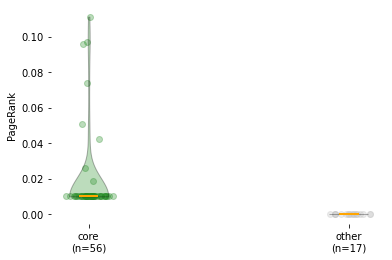

area:  SomMoCtx
population: 0
    time: 128007
    cells: 65
... Dynamical Analysis
    population firing: 3.34±2.79 sp/frame
    cells firing rate: 0.05±0.23 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 4.676413531624167
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 9008
    number of events per sec: 1.7618353755733103
    events duration: 0.090±0.040
    events size: 17.000±6.722
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.20754796714864582
    cluster size threshold: 2
    Total number of clusters: 179
    # clusters (after removing those below reproducibility threshold): 177
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cor

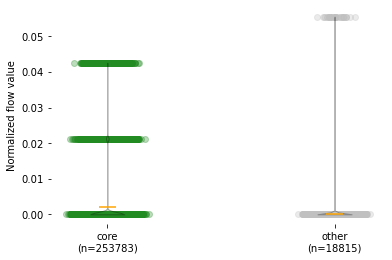


    Cut edges sourcing from cores: DescribeResult(nobs=47, minmax=(0.0, 121.87234042553192), mean=5.459483929379811, variance=384.65084849675196, skewness=4.8296200493983585, kurtosis=24.984980528101005)
    Cut edges targeting cores: DescribeResult(nobs=47, minmax=(0.0, 89.46808510638297), mean=5.474875509280218, variance=304.03419029627776, skewness=3.5724579505521383, kurtosis=12.464871093893832)
    Cut edges sourcing from others: DescribeResult(nobs=18, minmax=(0.0, 1.8888888888888888), mean=0.10493827160493827, variance=0.19821673525377226, skewness=3.880570000581328, kurtosis=13.058823529411768)
    Cut edges targeting others: DescribeResult(nobs=18, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Core targets vs sources Welch t test:  0.004 p= 0.997
    Kolmogorov-Smirnov Effect Size: 0.021
    Core targets vs Other targets Welch t test:  2.153 p= 0.037
    Kolmogorov-Smirnov Effect Size: 0.170


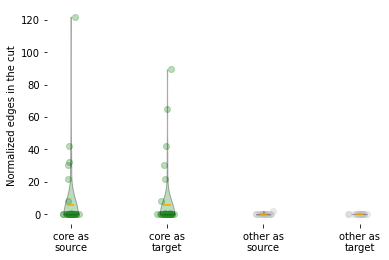

... PageRank centrality
    cores: DescribeResult(nobs=47, minmax=(0.011072165869390376, 0.1560576892131643), mean=0.02127659574468086, variance=0.0007495963245368347, skewness=3.322344831944826, kurtosis=11.596340368907486)
    others: DescribeResult(nobs=18, minmax=(0.0, 0.0), mean=0.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
    Kruskal-Wallis test:  47.535 p= 0.000
    Kolmogorov-Smirnov Effect Size: 1.000


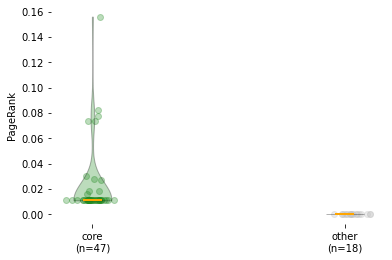

population: 1
    time: 128048
    cells: 26
... Dynamical Analysis
    population firing: 1.64±1.58 sp/frame
    cells firing rate: 0.06±0.28 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 2.2894557496176793
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 8115
    number of events per sec: 1.5881993752886745
    events duration: 0.090±0.039
    events size: 6.000±2.777
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.350415189240472
    cluster size threshold: 2
    Total number of clusters: 53
    # clusters (after removing those below reproducibility threshold): 53
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing unspecific

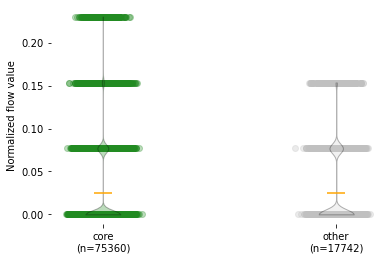


    Cut edges sourcing from cores: DescribeResult(nobs=13, minmax=(0.0, 668.9230769230769), mean=82.24260355029585, variance=33395.57085419512, skewness=2.8108810187600253, kurtosis=6.618608057501845)
    Cut edges targeting cores: DescribeResult(nobs=13, minmax=(0.0, 281.0769230769231), mean=74.0887573964497, variance=11194.06690942194, skewness=0.9858075233427703, kurtosis=-0.580026895187995)
    Cut edges sourcing from others: DescribeResult(nobs=13, minmax=(0.0, 90.53846153846153), mean=7.331360946745562, variance=625.9875587922926, skewness=3.1669789679874936, kurtosis=8.050099814363547)
    Cut edges targeting others: DescribeResult(nobs=13, minmax=(0.0, 138.15384615384616), mean=15.485207100591715, variance=1500.6798664846008, skewness=2.7142846822997635, kurtosis=6.108182780889575)
    Core targets vs sources Welch t test:  -0.139 p= 0.891
    Kolmogorov-Smirnov Effect Size: 0.154
    Core targets vs Other targets Welch t test:  1.875 p= 0.080
    Kolmogorov-Smirnov Effect Siz

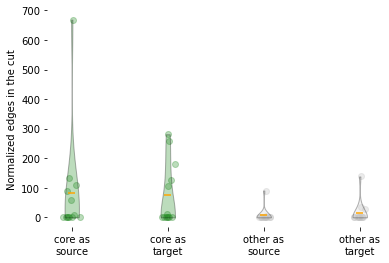

... PageRank centrality
    cores: DescribeResult(nobs=13, minmax=(0.016896648831315128, 0.3077496281945137), mean=0.06780851603192514, variance=0.007041585878683933, skewness=2.003735637646202, kurtosis=3.2032759999751823)
    others: DescribeResult(nobs=13, minmax=(0.0, 0.043597863994222774), mean=0.009114560891151794, variance=0.0003084047290988951, skewness=1.3667914003138086, kurtosis=-0.02068825724627299)
    Kruskal-Wallis test:  11.382 p= 0.001
    Kolmogorov-Smirnov Effect Size: 0.769


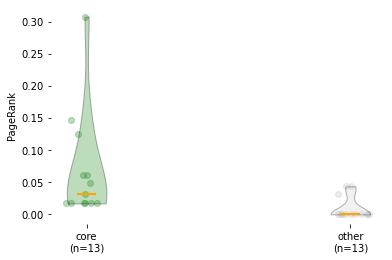

area:  V1
population: 0
    time: 129117
    cells: 61
... Dynamical Analysis
    population firing: 4.36±4.39 sp/frame
    cells firing rate: 0.07±0.30 sp/s
... generating surrogates to establish population event threshold
... loaded surrogates
    event size threshold (mean): 5.640008670111284
    find peaks
    find minima
    find population events
    signatures of population events
    number of events: 8628
    number of events per sec: 1.6901540884568824
    events duration: 0.100±0.043
    events size: 21.000±9.341
    Similarity of events matrix
    clustering - linkage
    surrogate events signatures for clustering threshold
   ... loaded surrogates
    cluster reproducibility threshold: 0.1891990294759251
    cluster size threshold: 2
    Total number of clusters: 91
    # clusters (after removing those below reproducibility threshold): 91
    event color assignment
    unique color assignments
    clustered similarity map
    finding cluster cores
    removing cores firing

In [ ]:
# start of spontaneous activity in each mouse (in seconds)
etstart = [3811, 3633, 3323]

for imouse,(mousename,areas) in enumerate(area_spiketrains.items()):
    print("\nmouse:",mousename)
    
    # # to reduce computations, use comments here
    # if mousename not in ["Robbins"]:
    # if mousename not in ["Krebs", "Waksman"]:
    # if mousename not in ["Waksman"]:
    #     continue
        
    exp_path = local_path + '%s/'%mousename
    exp_tstart = etstart[imouse]

    # reading behavior data to make statistics about event dependence on it
    # we will use the field 'stimulus' to store the avg motSVD of the frames 
    # The behavioral file is the processed version of a mouse face movie (time x pixels x pixels). 
    faces = sio.loadmat('stringer/7739750/faces/%s_face_proc.mat'%mousename, squeeze_me=True)
    video_timestamps = faces['times'] # same temporal resolution of ephy
    motSVD = faces['motionSVD']
    exp_istart = (np.abs(video_timestamps - exp_tstart)).argmin()    
    motSVD_1c = motSVD[:,0] # only first component
    motSVD_1c[motSVD_1c < -4000] = np.mean(motSVD_1c) # corrections
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(video_timestamps[exp_istart:], motSVD_1c[exp_istart:], linewidth=0.5, color='k')
    fig.savefig(exp_path+"/motSVD_%s.png"%mousename, transparent=True, dpi=900)
    plt.close()
    fig.clear()
    fig.clf()

    for area,probe_populations in areas.items():
        if len(probe_populations)>0:
            print("area: ",area)
            
            # # to reduce computations, use comments here
            # if area not in ['FrCtx', 'FrMoCtx']:
            # if area not in ['V1']:
            #     continue
                                    
            for ipop,spiketrains in enumerate(probe_populations): 
                print("population:",ipop)

                # rounding to ms
                # spiketrains = [np.round(sp, 3) for sp in spiketrains] # ms
                spiketrains = [np.round(sp, 2) for sp in spiketrains] # 10ms
                start_time = min([min(st) if len(st) else 0 for st in spiketrains])
                stop_time = max([max(st) if len(st) else 0 for st in spiketrains])
                time = np.arange(start_time,stop_time,frame_duration)
                print("    time:", len(time))
                print("    cells:", len(spiketrains))

                fig = plt.figure(figsize=[12.8,4.8])
                for row,train in enumerate(spiketrains):
                    plt.scatter( train, [row]*len(train), marker='o', edgecolors='none', s=1, c='k' )
                plt.ylabel("cell IDs")
                plt.xlabel("time (s)")
                # plt.show()
                fig.savefig(exp_path+'%s_%s_rasterplot.png'%(area,ipop), transparent=False, dpi=800)
                plt.tight_layout()
                plt.close()
                
                ophys_cell_ids = list(range(len(spiketrains)))
                ophys_cell_indexes = ophys_cell_ids # here is an alias

                scan_spiketrains = spiketrains
                scan_id = '_%s_%s'%(area,ipop)
                
                # --------------------------------------------------------------------------
                print("... Dynamical Analysis")
                core_reproducibility_perc = 99 # threshold for detecting cores
                %run "dynamical_analysis.ipynb"
                
                # # Match smooth motion energy curve with the cluster it belongs to
                # # Count the number of events belonging to a pattern before and after the change.
                # ccolors,ccounts = np.unique(cluster_color_array, return_counts=True)
                # cluster_events_counts = dict(zip(ccolors,ccounts))
                # Npre_beh_cluster = {el:0. for el in np.unique(cluster_color_array)}
                # Npost_beh_cluster = {el:0. for el in np.unique(cluster_color_array)}
                # for sni in smoothed_beh_indices:
                #     snitime = exp_tstart + sni * frame_duration
                #     snitime_pre = snitime - 0.15 # s
                #     snitime_post = snitime + 0.15 # s
                #     for ievent,(event,ecolor) in enumerate(zip(events,cluster_color_array)):
                #         event_start_time = exp_tstart + event['start'] * frame_duration
                #         if snitime_pre < event_start_time and event_start_time < snitime:
                #             Npre_beh_cluster[ecolor] += 1
                #         if snitime < event_start_time and event_start_time < snitime_post:
                #             Npost_beh_cluster[ecolor] += 1
                # # detail
                # fig = plt.figure()
                # plt.scatter(range(len(Npre_beh_cluster.keys())), Npre_beh_cluster.values(), marker='<', c=list(Npre_beh_cluster.keys()), edgecolors=list(Npre_beh_cluster.keys()), s=1)
                # plt.scatter(range(len(Npost_beh_cluster.keys())), Npost_beh_cluster.values(), marker='>', c=list(Npost_beh_cluster.keys()), edgecolors='none', s=1)
                # plt.vlines(range(len(Npost_beh_cluster.keys())), Npost_beh_cluster.values(), Npre_beh_cluster.values(), colors=list(Npost_beh_cluster.keys()), linewidths=0.6)
                # plt.ylabel('occurrence')
                # plt.xlabel('Patterns')
                # fig.savefig(exp_path+"/results/Pattern_behavior_%s_%s%s.png"%(mousename,area,ipop), transparent=True, dpi=600)
                # plt.close()
                # fig.clear()
                # fig.clf()
                # # summary
                # Nsame = 0
                # Npost = 0
                # Npre = 0
                # for pre,post in zip(Npre_beh_cluster.values(),Npost_beh_cluster.values()):
                #     if pre==post: Nsame +=1
                #     if pre>post: Npre +=1
                #     if pre<post: Npost +=1
                # fig = plt.figure()
                # plt.bar([0,1,2], [Npre,Nsame,Npost], width=0.8, color='C0')
                # plt.ylabel('occurrences')
                # plt.xlabel('pattern timing relative to movement')
                # plt.xticks(range(3),['before','same','after'])
                # fig.savefig(exp_path+"/results/Pattern_behavior_summary_%s_%s%s.png"%(mousename,area,ipop), transparent=True, dpi=600)
                # plt.close()
                # fig.clear()
                # fig.clf()
                
                # --------------------------------------------------------------------------
                # dimensional reduction, trajectories, and manifold analysis
                print("... Manifold Analysis")
                # %run "attractor_analysis.ipynb"

                # --------------------------------------------------------------------------
                # structural analysis
                print("... Structural Analysis")
                
                # make binary spiketrains
                print("    binary spiketrains")
                binary_spiketrains = np.zeros( (len(spiketrains),len(time)+2) )
                print("    shape:", binary_spiketrains.shape)
                for row,train in enumerate(spiketrains):
                    # iterate over spiketrains assigning 1 to the binary_spiketrains at the corresponding position
                    tidxs = np.trunc(train/frame_duration).astype(int) - int(exp_tstart/frame_duration)
                    tidxs[tidxs>len(time)] = len(time) 
                    binary_spiketrains[row][tidxs] = 1
                
                # --------------------------------------------------------------------------
                # functional connectivity matrix
                print("    starting functional adjacency matrix")
                functional_adjacency_matrix = []
                for irow,bsti in enumerate(binary_spiketrains):
                    row_xcorr = []
                    for jrow,bstj in enumerate(binary_spiketrains):
                        if irow==jrow:
                            row_xcorr.append(0.0) # no self connections
                            continue
                        row_xcorr.append(crosscorrelation(bsti, bstj, maxlag=1, mode='corr')[2])
                    functional_adjacency_matrix.append(row_xcorr)
                functional_adjacency_matrix = np.array(functional_adjacency_matrix)
                print("    full adjacency matrix:",functional_adjacency_matrix.shape)
                # To ensure sparseness of the matrix, discard weak correlations (<0.4, Sadovsky and MacLean 2013)
                functional_adjacency_matrix[ functional_adjacency_matrix <= functional_adjacency_matrix.max()*0.4 ] = 0.0
                np.save(exp_path+"/results/functional_adjacency_matrix_%s%s.npy"%(area,ipop), functional_adjacency_matrix)
                # plot
                fig = plt.figure()
                plt.pcolormesh(functional_adjacency_matrix)
                cbar = plt.colorbar()
                fig.savefig(exp_path+'/results/adjacency_matrix_%s%s.png'%(area,ipop), transparent=True)
                plt.close()
                fig.clear()
                fig.clf()
                
                # -----------------------------------------------------------------------------
                # is the cross-correlation between cells significant to justify a functional connectivity analysis?
                print("    checking details of best cross-correlation pairs ")
                # pick highly correlated cells for further inspection
                # thresholds for the top and bottom percentiles
                top_threshold = np.percentile(functional_adjacency_matrix, 95)
                highly_correlated_indices = np.where(functional_adjacency_matrix > top_threshold)
                bin_size = 1 # can be made lower
                lags = np.arange(-50, 51, bin_size)
                num_pairs = 30 if len(highly_correlated_indices[0])>30 else len(highly_correlated_indices[0])-1
                co_occurrence_counts = []
                surrogates_co_occurrence_counts = []
                for i in range(num_pairs):
                    spike_times1 = binary_spiketrains[highly_correlated_indices[0][i]].astype(int)
                    spike_times2 = binary_spiketrains[highly_correlated_indices[1][i]].astype(int)
                    co_occurrence_counts_per_lag = np.convolve(spike_times1, spike_times2[::-1], mode='same')
                    co_occurrence_counts.append(co_occurrence_counts_per_lag)
                    # geenrate surrogates by reshuffling
                    surrogates_co_occurrences = []
                    for j in range(10):
                        surrspike_times1 = np.random.permutation(spike_times1)
                        surrspike_times2 = np.random.permutation(spike_times2)
                        co_occurrence_counts_per_lag = np.convolve(surrspike_times1, surrspike_times2[::-1], mode='same')
                        surrogates_co_occurrences.append(co_occurrence_counts_per_lag)
                    surrogates_co_occurrence_counts.append(np.mean(surrogates_co_occurrences, axis=0))                    
                # grid of individual cross-correlations
                num_plots = len(co_occurrence_counts)
                num_rows = int(np.sqrt(num_plots))
                num_cols = int(np.ceil(num_plots / num_rows))
                fig = plt.figure(figsize=(15, 10))
                for i, co_occurrence_counts_pair in enumerate(co_occurrence_counts):
                    plt.subplot(num_rows, num_cols, i+1)
                    plt.plot(lags, co_occurrence_counts_pair[:len(lags)], color='blue')
                    plt.plot(lags, surrogates_co_occurrence_counts[i][:len(lags)], color='red', linestyle='dashed')
                fig.text(0.5, 0.04, 'Lag (ms)', ha='center')
                fig.text(0.04, 0.5, 'Correlation', va='center', rotation='vertical')
                plt.tight_layout()
                fig.savefig(exp_path+'/results/correlogram_%s%s.svg'%(area,ipop), transparent=True)
                plt.close()
                fig.clear()
                fig.clf()
                
                # -----------------------------------------------------------------------------
                # creating graph from functional_adjacency_matrix as in Sadovsky and MacLean 2013
                # functional_adjacency_matrix[ functional_adjacency_matrix <= functional_adjacency_matrix.max()*0.4 ] = 0.0
                functional_adjacency_matrix[ functional_adjacency_matrix >= functional_adjacency_matrix.max()*0.4 ] = 1.0
                
                dgraph = ig.Graph.Weighted_Adjacency(functional_adjacency_matrix, mode='directed')
                ig.plot(dgraph, exp_path+'/results/ring_%s%s.png'%(area,ipop), layout=dgraph.layout("circle"), edge_curved=0.2, edge_color='#000', edge_width=0.5, edge_arrow_size=0.1, vertex_size=5, vertex_color='#000', margin=50)
                print('    preparing vertex labels for cores and others')
                dgraph.vs["ophys_cell_id"] = ophys_cell_ids
                is_id_core = np.array( [0] * len(ophys_cell_ids) )
                is_id_core[core_indexes] = 1
                dgraph.vs["is_core"] = is_id_core.tolist()

                degrees = np.array(dgraph.degree())
                print("    Degree distributions")
                # https://igraph.org/python/api/latest/igraph._igraph.GraphBase.html#degree
                degdist = dgraph.degree_distribution(bin_width=5)
                degree_counts = [bi[2] for bi in degdist.bins()]
                fig = plt.figure()
                plt.plot(range(len(degree_counts)), degree_counts, linewidth=3.0)
                plt.ylabel('Number of vertices')
                plt.xlabel('Degree')
                plt.xscale('log')
                plt.yscale('log')
                plt.savefig(exp_path+'/results/degree_distribution_%s%s.png'%(area,ipop), transparent=True, dpi=300)
                plt.close()
                
                # Clustering Coefficient of only excitatory cells
                print('    Local Clustering Coefficient (cores too)')
                local_clustering_coefficients = np.array(dgraph.transitivity_local_undirected(vertices=None, mode="zero"))
                
                #--------------------------------------------------------------------
                # cores have low LCC

                # assign cores to their lcc and degree
                # print(core_indexes)
                core_local_clustering_coefficients = np.array(dgraph.transitivity_local_undirected(vertices=core_indexes, mode="zero"))
                core_degrees = np.array(dgraph.degree(vertices=core_indexes, mode="all"))

                # figure
                fig, (hmmap, chist) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [6, 1]})
                # hierarchy
                hmmap.scatter( degrees, local_clustering_coefficients, marker='o', facecolor='#111111', s=50, edgecolors='none', alpha=0.5) 
                hmmap.scatter( core_degrees, core_local_clustering_coefficients, marker='o', facecolor='none', s=50, edgecolors='forestgreen') 
                hmmap.set_yscale('log')
                hmmap.set_ylim([0.02,1.1])
                hmmap.set_xscale('log')
                hmmap.spines['top'].set_visible(False)
                hmmap.spines['right'].set_visible(False)
                hmmap.set_ylabel('LCC')
                hmmap.set_xlabel('degree')
                hmmap.tick_params(axis='both', bottom='on', top='on', left='off', right='off')
                # core lcc histogram
                bins = np.linspace(0.02,1,50)
                barheight = (max(local_clustering_coefficients)-min(local_clustering_coefficients))/50
                lcc_hist, lcc_binedges = np.histogram(core_local_clustering_coefficients, bins)
                chist.barh(bins[:-1], lcc_hist, height=barheight, align='center', color='green', linewidth=0)
                chist.spines['top'].set_visible(False)
                chist.spines['right'].set_visible(False)
                chist.tick_params(axis='x', which='both', bottom=True, top=False, labelsize='x-small')
                chist.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
                chist_ticks = chist.get_xticks()
                chist.set_ylim([0.01,1.1])
                chist.set_ylabel('LCC')
                chist.set_xlabel('count')
                chist.yaxis.set_label_position("right")
                chist.spines['top'].set_visible(False)
                chist.spines['right'].set_visible(False)
                chist.spines['bottom'].set_visible(False)
                plt.tight_layout()
                fig.savefig(exp_path+"/results/cores_hierarchical_modularity_%s%s.svg"%(area,ipop), transparent=True)
                plt.close()
                fig.clear()
                fig.clf()
                
                #--------------------------------------------------------------------
                # Flow analysis
                print("... Flow Analysis")
                
                if len(core_indexes)>1 and len(other_indexes)>1:
                    # The amount of flow on an edge cannot exceed the capacity of the edge.
                    # therefore, edges with high capacity will be more important for the flow.
                    # here we test the hypothesis that edges towards cores have higher capacity
                    # or that the sum of edges towards cores have a higher total capacity
                    cell_total_capacity = {cid:list() for cid in ophys_cell_ids}
                    edges_sourcing = {cid:0 for cid in ophys_cell_ids}
                    edges_targeting = {cid:0 for cid in ophys_cell_ids}

                    for cluster_k,events_cellids in scan_clustered_spectrums.items(): # we consider only the scan 0 because it's the largest (for now)
                        cluster_k = cluster_k.split(',')[0]

                        if cluster_k == 'gray':
                            continue

                        for vnt in events_cellids:
                            for posi,vidj in enumerate(vnt[1:]):
                                vidi = vnt[posi] # enumerate will go from 0
                                # print(vidi, vidj)

                                # check beginning and end are not the same
                                if dgraph.vs.find(ophys_cell_id=vidi).index == dgraph.vs.find(ophys_cell_id=vidj).index:
                                    continue
                                # # check there is a path between the two
                                # if len(spinesgraph.get_all_shortest_paths(spinesgraph.vs.find(name=vidi).index, to=spinesgraph.vs.find(name=vidj).index, weights=None, mode='out'))>0:
                                #     continue

                                # Take the maximum flow between the previous and next vertices
                                mfres = dgraph.maxflow(dgraph.vs.find(ophys_cell_id=vidi).index, dgraph.vs.find(ophys_cell_id=vidj).index)
                                # print(mfres)
                                # returns a tuple containing the following:
                                # graph - the graph on which this flow is defined
                                # value - the value (capacity) of the maximum flow between the given vertices
                                # flow - the flow values on each edge. For directed graphs, this is simply a list where element i corresponds to the flow on edge i.
                                # cut - edge IDs in the minimal cut corresponding to the flow.
                                # partition - vertex IDs in the parts created after removing edges in the cut
                                # es - an edge selector restricted to the edges in the cut.

                                # we get a flow value for each edge contributing to the flow.
                                # source
                                mfres_value = mfres.value
                                if vidi in np.array(ophys_cell_ids)[core_indexes]:
                                    mfres_value /= len(core_indexes)
                                else:
                                    mfres_value /= len(other_indexes)
                                cell_total_capacity[vidi].append(mfres_value)
                                # target
                                mfres_value = mfres.value
                                if vidj in np.array(ophys_cell_ids)[core_indexes]:
                                    mfres_value /= len(core_indexes)
                                else:
                                    mfres_value /= len(other_indexes)
                                cell_total_capacity[vidj].append(mfres_value)

                                # Iterate over the edges identified by the flow.
                                # count the edges sourcing from cores, and those targeting cores. Which is more?
                                for edge in mfres.es:
                                    sourceid = int(dgraph.vs[edge.source]['ophys_cell_id'])
                                    targetid = int(dgraph.vs[edge.target]['ophys_cell_id'])
                                    if sourceid in cell_total_capacity.keys():
                                        edges_sourcing[sourceid] +=1 # just count
                                    if targetid in cell_total_capacity.keys():
                                        edges_targeting[targetid] +=1 # just count

                    # Flow
                    # print(cell_total_capacity)
                    flowvalue_cores = []
                    for cid in np.array(ophys_cell_ids)[core_indexes]:
                        flowvalue_cores.extend(cell_total_capacity[cid])
                    flowvalue_others = []
                    for cid in np.array(ophys_cell_ids)[other_indexes]:
                        flowvalue_others.extend(cell_total_capacity[cid])

                    # description
                    print("    Flow cores: "+str(stats.describe(flowvalue_cores)) )
                    print("    Flow others: "+str(stats.describe(flowvalue_others)) )
                    # significativity
                    print("    Welch t test:  %.3f p= %.3f" % stats.ttest_ind(flowvalue_cores, flowvalue_others, equal_var=False))
                    d,_ = stats.ks_2samp(flowvalue_cores, flowvalue_others) # non-parametric measure of effect size [0,1]
                    print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

                    fig, ax = plt.subplots()
                    xs = np.random.normal(1, 0.04, len(flowvalue_cores))
                    plt.scatter(xs, flowvalue_cores, alpha=0.3, c='forestgreen')
                    xs = np.random.normal(2, 0.04, len(flowvalue_others))
                    plt.scatter(xs, flowvalue_others, alpha=0.3, c='silver')
                    vp = ax.violinplot([flowvalue_cores,flowvalue_others], widths=0.15, showextrema=False, showmeans=True)
                    for pc in vp['bodies']:
                        pc.set_edgecolor('black')
                    for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d']):
                        pc.set_facecolor(cb)
                    vp['cmeans'].set_color('orange')
                    # vp['cmedians'].set_linewidth(2.)
                    ax.spines['top'].set_visible(False)
                    ax.spines['bottom'].set_visible(False)
                    ax.spines['left'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    plt.ylabel('Normalized flow value')
                    plt.xticks([1, 2], ["core\n(n={:d})".format(len(flowvalue_cores)), "other\n(n={:d})".format(len(flowvalue_others))])
                    fig.savefig(exp_path+"/results/global_cores_others_flowvalue_%s%s.svg"%(area,ipop), transparent=True)
                    plt.show()
                    # fig.clf()
                    # plt.close()

                    print()
                    # Cuts
                    # print(edges_sourcing)
                    # print(edges_targeting)
                    flowcuts_core_sources = []
                    flowcuts_core_targets = []
                    for cid in np.array(ophys_cell_ids)[core_indexes]:
                        flowcuts_core_sources.append(edges_sourcing[cid]/len(core_indexes))
                        flowcuts_core_targets.append(edges_targeting[cid]/len(core_indexes))
                    flowcuts_other_sources = []
                    flowcuts_other_targets = []
                    for cid in np.array(ophys_cell_ids)[other_indexes]:
                        flowcuts_other_sources.append(edges_sourcing[cid]/len(other_indexes))
                        flowcuts_other_targets.append(edges_targeting[cid]/len(other_indexes))

                    # description
                    print("    Cut edges sourcing from cores: "+str(stats.describe(flowcuts_core_sources)) )
                    print("    Cut edges targeting cores: "+str(stats.describe(flowcuts_core_targets)) )
                    print("    Cut edges sourcing from others: "+str(stats.describe(flowcuts_other_sources)) )
                    print("    Cut edges targeting others: "+str(stats.describe(flowcuts_other_targets)) )
                    # significativity
                    print("    Core targets vs sources Welch t test:  %.3f p= %.3f" % stats.ttest_ind(flowcuts_core_targets, flowcuts_core_sources, equal_var=False))
                    d,_ = stats.ks_2samp(flowcuts_core_targets, flowcuts_core_sources) # non-parametric measure of effect size [0,1]
                    print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

                    print("    Core targets vs Other targets Welch t test:  %.3f p= %.3f" % stats.ttest_ind(flowcuts_core_targets, flowcuts_other_targets, equal_var=False))
                    d,_ = stats.ks_2samp(flowcuts_core_targets, flowcuts_other_targets) # non-parametric measure of effect size [0,1]
                    print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

                    fig, ax = plt.subplots()
                    xs = np.random.normal(1, 0.04, len(flowcuts_core_sources))
                    plt.scatter(xs, flowcuts_core_sources, alpha=0.3, c='forestgreen')
                    xs = np.random.normal(2, 0.04, len(flowcuts_core_targets))
                    plt.scatter(xs, flowcuts_core_targets, alpha=0.3, c='forestgreen')
                    xs = np.random.normal(3, 0.04, len(flowcuts_other_sources))
                    plt.scatter(xs, flowcuts_other_sources, alpha=0.3, c='silver')
                    xs = np.random.normal(4, 0.04, len(flowcuts_other_targets))
                    plt.scatter(xs, flowcuts_other_targets, alpha=0.3, c='silver')
                    vp = ax.violinplot([flowcuts_core_sources,flowcuts_core_targets,flowcuts_other_sources,flowcuts_other_targets], widths=0.15, showextrema=False, showmeans=True)
                    for pc in vp['bodies']:
                        pc.set_edgecolor('black')
                    for pc in vp['bodies'][0:2]:
                        pc.set_facecolor('#228B224d')
                    for pc in vp['bodies'][2:]:
                        pc.set_facecolor('#D3D3D34d')
                    vp['cmeans'].set_color('orange')
                    # vp['cmedians'].set_linewidth(2.)
                    ax.spines['top'].set_visible(False)
                    ax.spines['bottom'].set_visible(False)
                    ax.spines['left'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    plt.ylabel('Normalized edges in the cut')
                    plt.xticks([1, 2, 3, 4], ["core as\nsource", "core as\ntarget", "other as\nsource", "other as\ntarget"])
                    fig.savefig(exp_path+"/results/global_cores_others_cutvalue_%s%s.svg"%(area,ipop), transparent=True)
                    plt.show()
                    # fig.clf()
                    # plt.close()
                    
                print('... PageRank centrality')
                pagerank_cores = np.array(dgraph.personalized_pagerank(vertices=core_indexes, directed=True, damping=0.85, reset="is_core"))
                pagerank_others = np.array(dgraph.personalized_pagerank(vertices=other_indexes, directed=True, damping=0.85, reset="is_core"))
                # description
                print("    cores: "+str(stats.describe(pagerank_cores)) )
                print("    others: "+str(stats.describe(pagerank_others)) )
                # significativity
                print("    Kruskal-Wallis test:  %.3f p= %.3f" % stats.kruskal(pagerank_cores, pagerank_others))
                d,_ = stats.ks_2samp(pagerank_cores, pagerank_others) # non-parametric measure of effect size [0,1]
                print('    Kolmogorov-Smirnov Effect Size: %.3f' % d)

                fig, ax = plt.subplots()
                xs = np.random.normal(1, 0.04, len(pagerank_cores))
                plt.scatter(xs, pagerank_cores, alpha=0.3, c='forestgreen')
                xs = np.random.normal(2, 0.04, len(pagerank_others))
                plt.scatter(xs, pagerank_others, alpha=0.3, c='silver')
                vp = ax.violinplot([pagerank_cores,pagerank_others], widths=0.15, showextrema=False, showmedians=True)
                for pc in vp['bodies']:
                    pc.set_edgecolor('black')
                for pc,cb in zip(vp['bodies'],['#228B224d','#D3D3D34d']):
                    pc.set_facecolor(cb)
                vp['cmedians'].set_color('orange')
                vp['cmedians'].set_linewidth(2.)
                ax.spines['top'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.spines['right'].set_visible(False)
                plt.ylabel('PageRank')
                plt.xticks([1, 2], ["core\n(n={:d})".format(len(pagerank_cores)), "other\n(n={:d})".format(len(pagerank_others))])
                fig.savefig(exp_path+'/results/global_cores_others_pagerank.svg', transparent=True)
                plt.show()
                #--------------------------------------------------------------------
                
    gc.collect()
    print()    